# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import numpy as np
import keras
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout, Input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


In [3]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [4]:
import re
from random import shuffle
from glob import glob

train_files = glob('./train/*.jpg')
test_files = glob('./test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*dog\.\d+.*', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

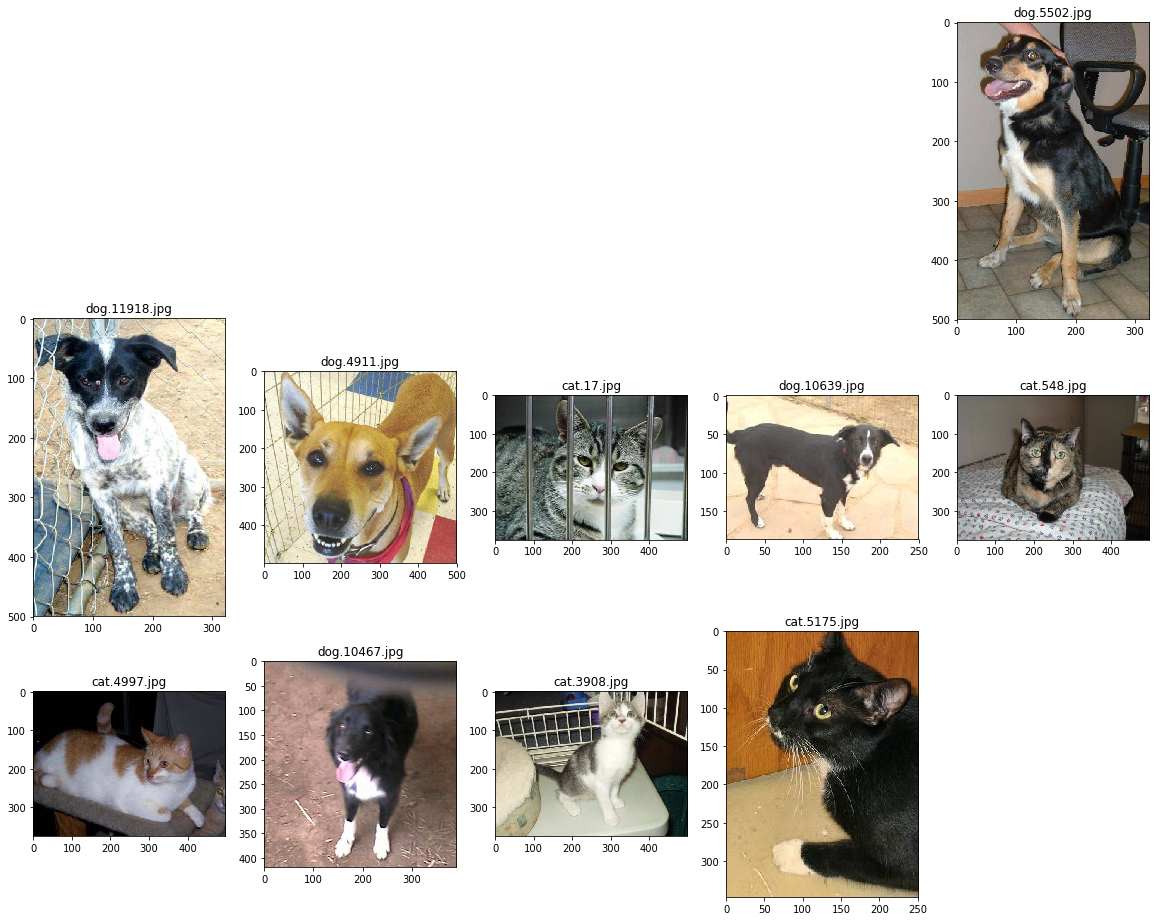

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [6]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))


In [7]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False
    
last = base_model.output

## Добавляем полносвязный слой

In [9]:
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Компилируем модель и запускаем обучение

In [11]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [12]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))



In [13]:
# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
                    steps_per_epoch=30,  # число вызовов генератора за эпоху
                    epochs=200,  # число эпох обучения
                    validation_data=validation_data)

Epoch 1/200
30/30 [==============================] - 7s - loss: 1.5987 - acc: 0.8833 - val_loss: 0.5357 - val_acc: 0.9600
Epoch 2/200
30/30 [==============================] - 5s - loss: 1.2531 - acc: 0.9187 - val_loss: 0.6458 - val_acc: 0.9500
Epoch 3/200
30/30 [==============================] - 5s - loss: 1.2874 - acc: 0.9156 - val_loss: 0.1764 - val_acc: 0.9800
Epoch 4/200
30/30 [==============================] - 5s - loss: 1.5533 - acc: 0.8969 - val_loss: 0.3675 - val_acc: 0.9700
Epoch 5/200
30/30 [==============================] - 5s - loss: 1.0302 - acc: 0.9344 - val_loss: 0.3992 - val_acc: 0.9700
Epoch 6/200
30/30 [==============================] - 5s - loss: 0.9177 - acc: 0.9406 - val_loss: 1.9131 - val_acc: 0.8800
Epoch 7/200
30/30 [==============================] - 5s - loss: 0.9915 - acc: 0.9323 - val_loss: 0.9653 - val_acc: 0.9400
Epoch 8/200
30/30 [==============================] - 5s - loss: 0.8785 - acc: 0.9427 - val_loss: 0.4818 - val_acc: 0.9700
Epoch 9/200
30/30 [=====

## Предсказания на проверочной выборке

In [14]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

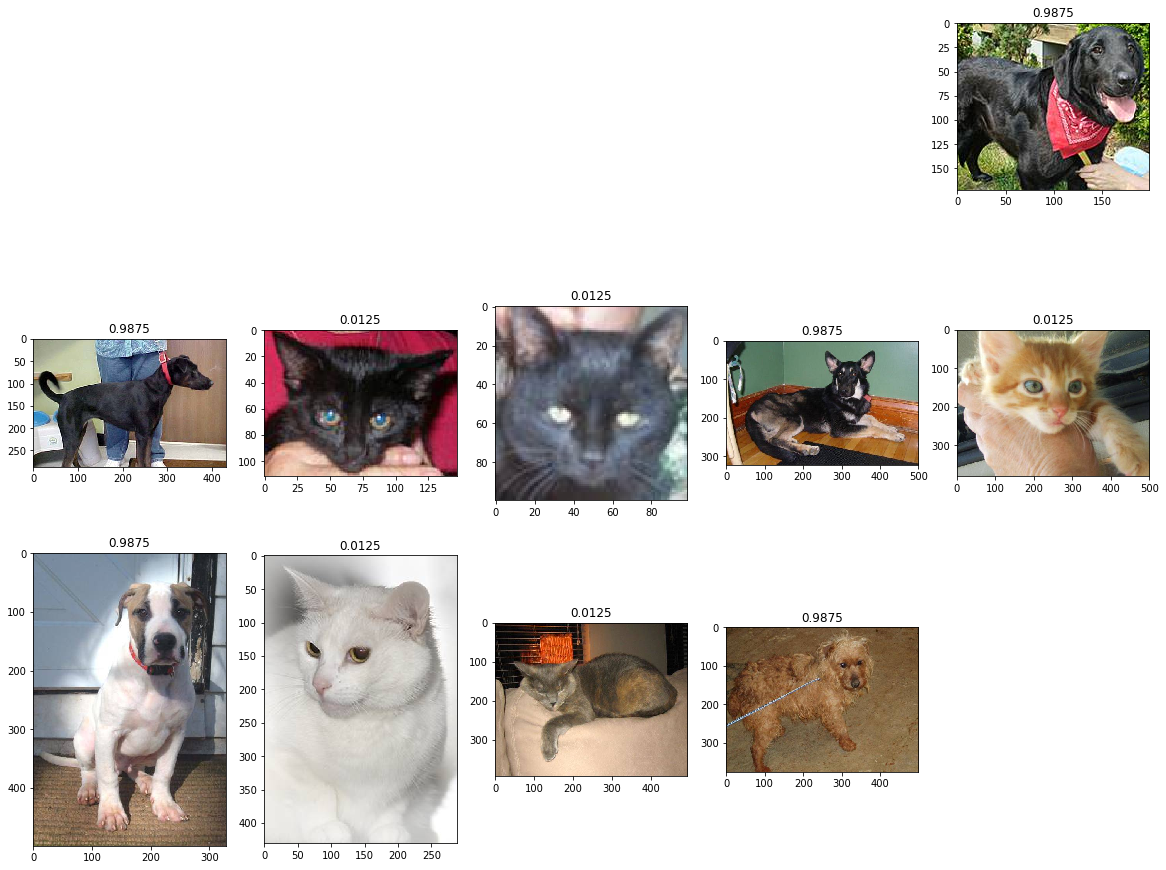

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[60:][:10], pred[60:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.4f' % score);

## Готовим данные для сабмита

In [19]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    pred= np.clip(pred,0.0125,0.9875)
    for path, score in zip(test_files, pred):
        dst.write('%s,%.4f\n' % (re.search('(\d+)', path).group(0), score[0]))

![title](result/res_lab_3.png)